## Notebook 2 : Données spatio-temporelles et plaquages

#  Vitesse

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
data=pd.read_csv('LOU MHR Export for Delon Armitage 43636.csv',skiprows=8,sep=";")
data=data.replace(',','.',regex=True)
data[["Latitude","Longitude","Velocity","Odometer"]]=data[["Latitude","Longitude","Velocity","Odometer"]].apply(pd.to_numeric)
liste=data.Latitude
liste=liste.replace(',','.',regex=True)

On calcule une première fois la vitesse instanée en appliquant la definition de la vitesse instantannée. v=(Xi+1-Xi)/dt

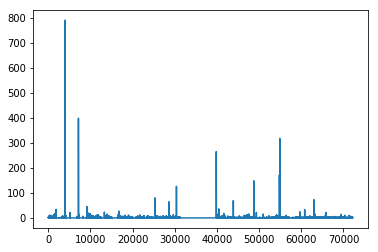

In [4]:
data["Vitesse"]=[(data["Odometer"][i+1]-data["Odometer"][i])/0.1 for i in range(len(data)-1)]+[0]
data["Vitesse"].plot()


On obtient beaucoup de valeurs aberrante. Deux solutions s'offre à nous: soit on supprime ces valeurs soit on lisse la courbe. On commence par lisser la courbe de position (technique de la moyenne mobile) pour limiter le bruit de sa dérivé.

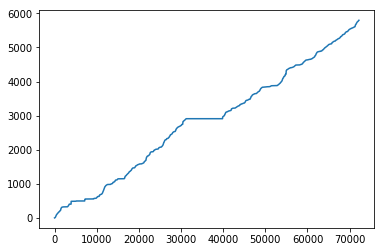

In [5]:
Lcad=[(data["Odometer"][i]+data["Odometer"][i+1]+data["Odometer"][i+2]+data["Odometer"][i+3]+data["Odometer"][i+4])/5 for i in range(len(data)-4)]
data["OdometerLisse"]=[0,0]+Lcad+[Lcad[-1],Lcad[-1]]
data["OdometerLisse"].plot()

On limite encore plus le bruit sur la courbe de vitesse en appliquant cette definition:: v=(Xi+2-Xi-2)/dt. Ainsi l'erreur est diminuée pour chaque point.

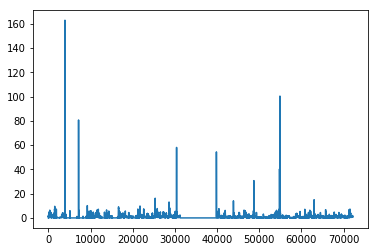

In [6]:
L=[((data["OdometerLisse"][i+2]-data["OdometerLisse"][i-2])/0.4) for i in range(2,len(data)-2)]
data["VitesseLisse"]=[0]+[0]+L+[L[-1],L[-1]]
data["VitesseLisse"].plot()

 On voit bien qu'en lissant l'erreur a été diminué par 5. Il ne nous reste alors plus qu'à supprimer les points aberrants. On décide pour ça desupprimer les valeurs superieurs a 12 m/s (c'est le record d'Usain Bolt sur 100m).


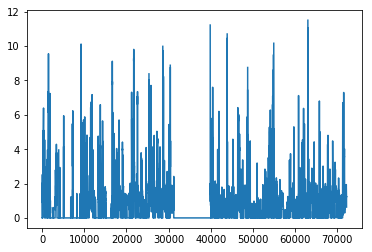

In [7]:
l=[]
for x in data["VitesseLisse"]:
    if x<12:
        l.append(x)
    else:
        l.append(None)
data["Vitesse2"]=l
data["Vitesse2"].plot()
        

On lisse encore une fois la courbe de la meme maniere que precedement.

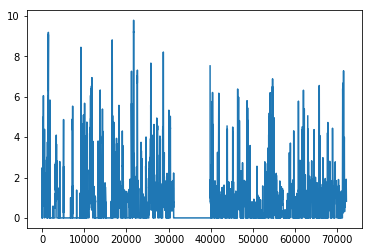

In [8]:
Lcad=[(data["Vitesse2"][i]+data["Vitesse2"][i+1]+data["Vitesse2"][i+2]+data["Vitesse2"][i+3]+data["Vitesse2"][i+4])/5 for i in range(len(data)-4)]
data["Vitesse2Lisse"]=[0,0]+Lcad+[Lcad[-1],Lcad[-1]]
data["Vitesse2Lisse"].plot()

# Accelerations


On calcule laccélération à l aide de la formule A(Xi)=(V(Xi+1)-V(Xi))/dt en utilisant la première donnée de vitesse calculée (non lissée). Comme attendu, les résultats de l'accélération présentent de nombreuses valeurs aberrantes.

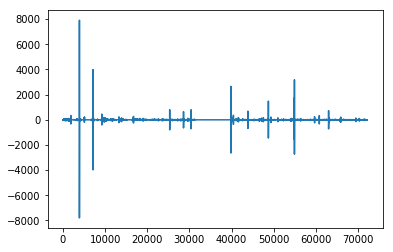

In [16]:
data["Acceleration"]=[(data["Vitesse"][i+1]-data["Vitesse"][i])/0.1 for i in range(len(data)-1)]+[0]
data["Acceleration"].plot()

On utilise alors la vitesse lissée, et on trouve des résultats plus cohérents.

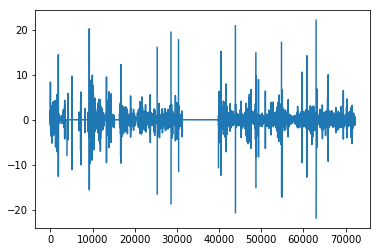

In [18]:
data["Acceleration"]=[(data["Vitesse2Lisse"][i+1]-data["Vitesse2Lisse"][i])/0.1 for i in range(len(data)-1)]+[0]
data["Acceleration"].plot()

# Accelerations et plaquages

On met maintenant en place une méthode permettant d'extraire les décélérations les plus importantes, pouvant s'apparenter à des plaquages (par exemple celle supérieures à 8m.s^-2.).

In [21]:
Decelerationsimportantes=[[],[]]
for k in range(len(data["Acceleration"])):
    if data["Acceleration"][k]<-10:
        Decelerationsimportantes[0].append(data["Acceleration"][k])
        Decelerationsimportantes[1].append(data['Timestamp'][k])
print(Decelerationsimportantes)
print('Le nombre de décélérations pouvant s apparenter à des plaquages est de :',len(Decelerationsimportantes[0]))

[[-12.580000000000098, -12.320000000000277, -11.06000000000023, -10.019999999999527, -14.559999999999604, -15.559999999999832, -13.339999999999463, -16.499999999998636, -18.65000000000009, -12.279999999998381, -11.470000000003893, -10.639999999996235, -12.339999999999236, -12.229999999999563, -20.66000000000031, -13.840000000000146, -15.059999999998581, -16.890000000007603, -15.370000000007167, -12.850000000003092, -17.200000000002547, -12.280000000000655, -12.75000000000091, -21.81999999999789, -14.909999999999854], ['05.05.2018 21:03', '05.05.2018 21:03', '05.05.2018 21:09', '05.05.2018 21:12', '05.05.2018 21:15', '05.05.2018 21:15', '05.05.2018 21:15', '05.05.2018 21:42', '05.05.2018 21:48', '05.05.2018 21:48', '05.05.2018 21:51', '05.05.2018 22:07', '05.05.2018 22:08', '05.05.2018 22:08', '05.05.2018 22:13', '05.05.2018 22:13', '05.05.2018 22:21', '05.05.2018 22:31', '05.05.2018 22:31', '05.05.2018 22:31', '05.05.2018 22:32', '05.05.2018 22:41', '05.05.2018 22:41', '05.05.2018 22:4

Cette méthode étant ponctuelle, elle est très susceptible de donner des résultats erronés ou très peu précis.

# Vitesse et plaquages

A partir de la Vitesse, nous allons essayer de trouver un moyen de repérer les décélérations brusques, qui pourraient correspondre à un plaquage. On met alors en place une méthode qui permet de repérer les diminutions 5m.s^-1(choisi arbitrairement pour l'instant) en une demi seconde (durée approximative d'un plaquage).

In [9]:
l=list(data["Vitesse2"])
len(l)

72200

In [13]:
i=0
a=0
ListePlaquage=[]
while i< (len(l)-5):
    if l[i+5]-l[i]<-5:
        
        a+=1
        i+=10
    i+=1
print('Le nombre de décélérations pouvant s apparenter à des plaquages est de :', a )

Le nombre de décélérations pouvant s apparenter à des plaquages est de : 15


On réalise maintenant la même chose pour différentes valeurs de décélérations. En effet, il est difficile de quantifier une décélération due à un plaquage. L'idée est donc de tracer une courbe du nombre de décélérations en fonction de la valeur de décélérations choisies, et d'essayer de déterminer pour quelle valeur le nombre de décélérations peut s'apparenter à un nombre de plaquages par match.

In [15]:
alpha=0
Lalpha=[]
Lrec=[]
while alpha>-11:
    i=0
    a=0
    
    ListePlaquage=[]
    while i< (len(l)-5):
        if l[i+5]-l[i]<alpha:
            a+=1
            i+=10
        i+=1
    Lalpha.append(alpha)
    Lrec.append(a)
    alpha
    alpha-=0.5
    


        
    
    

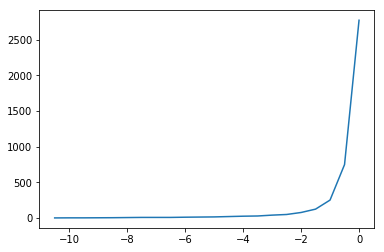

In [12]:
plt.plot(Lalpha,Lrec)

En utilisant cette courbe, une conclusion pourrait être tirée par exemple en regardant le match en question et en comptant le nombre de plaquages 

# Conclusion

Dans ce notebook, nous avons, à partir de données de position, élaboré tout d'abord une nouvelle donnée : la vitesse. En  utilisant le principe de la moyenne mobile et en supprimant les poins aberrants, nous sommes parvenus à constituer une liste de vitesse pertinente. Nous en avons ensuite tiré une liste des accélérations du joueur tout au long du match.

Nous avons ensuite mis en place des méthodes permettant, à partir de la vitesse et de l'accélération, permettant à priori de repérer tout au long du match les décélérations assez importantes, pouvant s'apparenter à un plaquage.

Le défaut principal de ce travail, est justement la difficulté à quantifier précisement ( en terme de décélération) le phénomène du plaquage.